In [1]:
import numpy as np
import pandas as pd
import copy
import time
from numpy import array
import matplotlib.pyplot as plt
import warnings
import joblib
import statistics
import random
from openTSNE import TSNE
from sklearn.cluster import KMeans
import math
warnings.filterwarnings("ignore")

## Data Process

In [2]:
# Load the data
df_raw = pd.read_csv('Medicalpremium.csv')

In [3]:
df_raw

Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0     45         0                      0               0                   0   
1     60         1                      0               0                   0   
2     36         1                      1               0                   0   
3     52         1                      1               0                   1   
4     38         0                      0               0                   1   
..   ...       ...                    ...             ...                 ...   
981   18         0                      0               0                   0   
982   64         1                      1               0                   0   
983   56         0                      1               0                   0   
984   47         1                      1               0                   0   
985   21         0                      0               0                   0   

     Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0       155      57               0                        0   
1       180      73               0                        0   
2       158      59               0                        0   
3       183      93               0                        0   
4       166      88               0                        0   
..      ...     ...             ...                      ...   
981     169      67               0                        0   
982     153      70               0                        0   
983     155      71               0                        0   
984     158      73               1                        0   
985     158      75               1                        0   

     NumberOfMajorSurgeries  PremiumPrice  
0                         0         25000  
1                         0         29000  
2                         1         23000  
3                         2         28000  
4                         1         23000  
..                      ...           ...  
981                       0         15000  
982                       3         28000  
983                       1         29000  
984                       1         39000  
985                       1         15000  

[986 rows x 11 columns]

In [4]:
# Seperate X and y
def separate_Xy(data):
    
    X_names = data.columns.values.tolist()
    X_names.remove('PremiumPrice')
    X = data[X_names]
    y = data['PremiumPrice']
    
    return X, y

In [5]:
"""
Code modified based on openTSNE examples
original author: @ pavlin-policar
"""
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib
    import matplotlib.pyplot

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=12, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

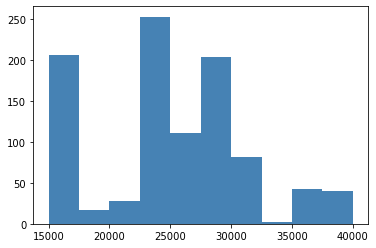

In [6]:
# Show the distribution of the dataset
X, y = separate_Xy(df_raw)
ax = plt.subplot()
plt.hist(y, color='steelblue')
plt.show()

From the distribution map, we guess that the data may be naturally clustered into three piles, and the insurance premiums for different segments may be calculated in different ways. In order to verify the initial guess, we decided to use an unsupervised clustering method to visualize the data dimensionality reduction. The TSNE algorithm initialized with PCA is selected for dimensionality reduction. This is because simply reducing PCA to 2 dimensions may lose too much information, that is, the number of important principal components is greater than 2. The pseudo-labels generated by K-means clustering are used to evaluate the effect of clustering to adjust hyperparameters. The entire training process does not involve labels, and labels are only used in the final visualization.

In [7]:
# Seperate y into 3 groups
def separate_y(y):
    y_n = copy.deepcopy(y)
    for i in range(len(y)):
        if y[i] < 20000:
            y_n[i] = '< 20000'
        elif (y[i] >= 20000) and (y[i] < 32500):
            y_n[i] = '20000 to 32500'
        else:
            y_n[i] = '> 32500'
    return y_n

In [8]:
best_score = float('-inf')
best_embedding = None
best_perplexity = 0
y_n = separate_y(y)

In [9]:
for i in range(100, 160):
    tsne = TSNE(n_components=3, perplexity=i, early_exaggeration_iter=500, early_exaggeration=12, n_iter=1000, \
                    initialization='pca', metric='euclidean', n_jobs=-1, neighbors='auto', random_state=200, verbose=False)
    embedding = tsne.fit(X)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(embedding)
    score = kmeans.score(embedding)
    if score > best_score:
        best_score = copy.deepcopy(score)
        best_embedding = copy.deepcopy(embedding)
        best_perplexity = copy.deepcopy(i)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


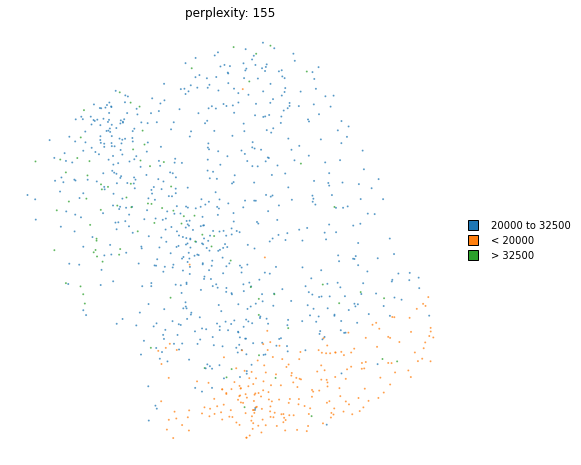

In [17]:
plot(best_embedding, y_n, title='perplexity: '+str(best_perplexity))

The result of clustering does not completely meet our hypothesis. Low insurance premiums (<20000) can be distinguished relatively easily, but there is no obvious distinction between medium and high insurance premiums. In order to further verify the previous ideas, we decided to compare the accuracy of the single regression model and the classification-regression model. The latter means to classify the data first, and then use regression models for low insurance premiums/high insurance premiums based on the results of classification predictions.

## Training Models

In [11]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

## Applying linear regression
First we try to apply linear regression on the whole group of data

In [24]:
df_regression_X, df_regression_Y = separate_Xy(df_raw)
Re_train_X, Re_test_X, Re_train_Y, Re_test_Y = train_test_split(df_regression_X, df_regression_Y, test_size = 0.2, random_state = 200)
reg = LinearRegression().fit(Re_train_X, Re_train_Y)
print('The training score of linear regression model is: ' + str(format(reg.score(Re_train_X, Re_train_Y), '.3g')))
print('The testing score of linear regression model is: ' + str(format(reg.score(Re_test_X, Re_test_Y), '.3g')))

The training accuracy of linear regression model is: 0.65
The testing accuracy of linear regression model is: 0.61


Obviously, linear regression is not a good model for predicting a person's insurance premium.

## Applying random forest regression 

In [269]:
df_regression_X = df_raw.iloc[:,0:10]
df_regression_Y = df_raw.iloc[:,10:11]
Re_train_X, Re_test_X, Re_train_Y, Re_test_Y = train_test_split(df_regression_X, df_regression_Y, test_size = 0.3, random_state = 200)
regr = RandomForestRegressor(n_jobs = -1)
regr.fit(Re_train_X, Re_train_Y)
Re_train_predict = regr.predict(Re_train_X)
Re_train_predict = np.array(Re_train_predict)
Re_train_predict = Re_train_predict.reshape((690,1)).astype(int)

In [270]:
regr.score(Re_train_X,Re_train_Y, sample_weight=None)

0.9678041560056123

In [271]:
regr.score(Re_test_X,Re_test_Y, sample_weight=None)

0.8207314064727796

We decied to use random forest regression for our final regression method based on its best proformance on raw data

## Applying polynomial regression

In [ ]:
df_regression_X = df_raw.iloc[:,0:10]
df_regression_Y = df_raw.iloc[:,10:11]
Re_train_X, Re_test_X, Re_train_Y, Re_test_Y = train_test_split(df_regression_X, df_regression_Y, test_size = 0.2, random_state = 200)
poly = PolynomialFeatures(degree = 3)
poly_x = poly.fit_transform(Re_train_X)
poly_test_x = poly.fit_transform(Re_test_X)
lin_reg2 = LinearRegression()
lin_reg2.fit(poly_x, Re_train_Y)

In [ ]:
lin_reg2.score(poly_x, Re_train_Y)

In [ ]:
lin_reg2.score(poly_test_x, Re_test_Y)

# Clustering with our inital assumption about data

In [ ]:
# first randomly pick 80% of data and divide into >20000 and <=20000 group
# then calculate group mean with normalization and train two decision trees
# apply the algorithm to the test group

In [ ]:
Clu_train, Clu_test = train_test_split(df_raw, test_size = 0.2, random_state = 200)
Clu_train1 = Clu_train[Clu_train['PremiumPrice'] > 20000]
Clu_train2 = Clu_train[Clu_train['PremiumPrice'] <= 20000]
Clu_train1_X = Clu_train1.iloc[:,0:10]
Clu_train1_Y = Clu_train1.iloc[:,10:11]
Clu_train2_X = Clu_train2.iloc[:,0:10]
Clu_train2_Y = Clu_train2.iloc[:,10:11]
Clu_train1_X_norm = preprocessing.normalize(Clu_train1_X, axis = 0)
Clu_train2_X_norm = preprocessing.normalize(Clu_train2_X, axis = 0)
regr1 = RandomForestRegressor(n_jobs = -1)
regr1.fit(Clu_train1_X_norm, Clu_train1_Y)
regr2 = RandomForestRegressor(n_jobs = -1)
regr2.fit(Clu_train2_X_norm, Clu_train2_Y)
Mean1 = Clu_train1_X_norm.mean(axis = 0)
Mean2 = Clu_train2_X_norm.mean(axis = 0)

In [ ]:
regr1.score(Clu_train1_X_norm, Clu_train1_Y , sample_weight=None)

In [ ]:
Clu_test_X_norm = preprocessing.normalize(Clu_test.iloc[:,0:10], axis = 0)

In [ ]:
rep1 = np.repeat(Mean1, 198, axis = 0).reshape(10,198).T

In [ ]:
rep2 = np.repeat(Mean2, 198, axis = 0).reshape(10,198).T

In [ ]:
distance1 = []
distance2 = []
for i in range(len(Clu_test_X_norm)):
    distance1.append(math.dist(Clu_test_X_norm[i], Mean1))
    distance2.append(math.dist(Clu_test_X_norm[i], Mean2))

In [ ]:
cluster1 = []
cluster2 = []
for i in range(len(Clu_test_X_norm)):
    if distance1[i] > distance2[i]:
        cluster2.append(Clu_test_X_norm[i])
    else:
        cluster1.append(Clu_test_X_norm[i])

In [ ]:
len(cluster1)

In [ ]:
len(cluster2)

## Classification-regression model

In [25]:
def bin_sep_y(y):
    y_n = copy.deepcopy(y)
    for i in range(len(y)):
        if y[i] < 20000:
            y_n[i] = '< 20000'
        else:
            y_n[i] = '> 20000'
    return y_n

In [31]:
X, y = separate_Xy(df_raw)
clf_y = bin_sep_y(y)
train_X, test_X, train_y, test_y = train_test_split(X, clf_y, test_size=0.2, random_state=200)

In [28]:
clf = RandomForestClassifier(random_state=200, oob_score=True)
param_grid = {'min_samples_split':[0.0001, 0.001, 0.01], 'min_samples_leaf':list(range(1, 10))}
scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score)}
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, scoring=scoring, refit='balanced_accuracy', return_train_score=False)
grid_search.fit(train_X, train_y)
clf_model=grid_search.best_estimator_

In [30]:
print('The training accuracy of linear regression model is: ' + str(format(clf_model.score(train_X, train_y), '.3g')))
print('The testing accuracy of linear regression model is: ' + str(format(clf_model.score(test_X, test_y), '.3g')))

The training accuracy of linear regression model is: 0.984
The testing accuracy of linear regression model is: 0.975


As we assumed, the classifier can distinguish low insurance premiums (<20000) from high insurance premiums. Therefore, we then try to train different regressors on the classified two sets of data.

In [93]:
# <20000
df_low = df_raw[df_raw['PremiumPrice'] < 20000]
X, y = separate_Xy(df_low)
Re_train_X, Re_test_X, Re_train_Y, Re_test_Y = train_test_split(X, y, test_size=0.2, random_state=200)

In [94]:
regr = RandomForestRegressor(random_state=200, n_jobs=-1)
regr.fit(Re_train_X, Re_train_Y)
print('The training accuracy of linear regression model is: ' + str(format(regr.score(Re_train_X, Re_train_Y), '.3g')))
print('The testing accuracy of linear regression model is: ' + str(format(regr.score(Re_test_X, Re_test_Y), '.3g')))

The training accuracy of linear regression model is: 0.991
The testing accuracy of linear regression model is: -0.267


In [95]:
# >20000
df_high = df_raw[df_raw['PremiumPrice'] >= 20000]
X, y = separate_Xy(df_high)
Re_train_X, Re_test_X, Re_train_Y, Re_test_Y = train_test_split(X, y, test_size=0.2, random_state=200)

In [96]:
regr = RandomForestRegressor(random_state=200, n_jobs=-1)
regr.fit(Re_train_X, Re_train_Y)
print('The training accuracy of linear regression model is: ' + str(format(regr.score(Re_train_X, Re_train_Y), '.3g')))
print('The testing accuracy of linear regression model is: ' + str(format(regr.score(Re_test_X, Re_test_Y), '.3g')))

The training accuracy of linear regression model is: 0.961
The testing accuracy of linear regression model is: 0.766


# K-Means clustering 

In [286]:
Kmeans_train, Kmeans_test = train_test_split(df_raw, test_size = 0.3, random_state = 200)
Kmeans_train_X = Kmeans_train.iloc[:,0:10]
Kmeans_test_X = Kmeans_test.iloc[:,0:10]
Kmeans_test_X_norm = pd.DataFrame(preprocessing.normalize(Kmeans_test_X, axis = 0))
Kmeans_train_X_norm = pd.DataFrame(preprocessing.normalize(Kmeans_train_X, axis = 0))
kmeans = KMeans(n_clusters = 2).fit(Kmeans_train_X_norm)
Kmeans_train_X_norm['Label'] = kmeans.labels_
Clu_0 = []
Clu_1 = []
y_0 = []
y_1 = []
for i in range(690):
    if Kmeans_train_X_norm['Label'][i] == 0:
        Clu_0.append(pd.DataFrame(Kmeans_train_X).to_numpy()[i,0:10])
        y_0.append(pd.DataFrame(Kmeans_train).to_numpy()[i,10:11])
    if Kmeans_train_X_norm['Label'][i] == 1:
        Clu_1.append(pd.DataFrame(Kmeans_train_X).to_numpy()[i,0:10])
        y_1.append(pd.DataFrame(Kmeans_train).to_numpy()[i,10:11])
regr0 = RandomForestRegressor(n_jobs = -1)
regr0.fit(Clu_0, y_0)
regr1 = RandomForestRegressor(n_jobs = -1)
regr1.fit(Clu_1, y_1)
Kmeans_test_X_norm['Label']  = kmeans.predict(Kmeans_test_X_norm)
Clu_0 = []
Clu_1 = []
y_0 = []
y_1 = []
for i in range(296):
    if Kmeans_test_X_norm['Label'][i] == 0:
        Clu_0.append(pd.DataFrame(Kmeans_test_X).to_numpy()[i,0:10])
        y_0.append(pd.DataFrame(Kmeans_test).to_numpy()[i,10:11])
    if Kmeans_test_X_norm['Label'][i] == 1:
        Clu_1.append(pd.DataFrame(Kmeans_test_X).to_numpy()[i,0:10])
        y_1.append(pd.DataFrame(Kmeans_test).to_numpy()[i,10:11])
regr0.score(Clu_0,y_0)

0.7934626939604212

In [287]:
regr1.score(Clu_1,y_1)

0.9567272328985363

In [288]:
(regr0.score(Clu_0,y_0)*len(y_0)+regr1.score(Clu_1,y_1)*len(y_1))/296

0.8000815266200746

In [289]:
len(y_0)

284

In [290]:
len(y_1)

12

In [292]:
Kmeans_train, Kmeans_test = train_test_split(df_raw, test_size = 0.2, random_state = 200)
Kmeans_train_X = Kmeans_train.iloc[:,0:10]
Kmeans_test_X = Kmeans_test.iloc[:,0:10]
Kmeans_test_X_norm = pd.DataFrame(preprocessing.normalize(Kmeans_test_X, axis = 0))
Kmeans_train_X_norm = pd.DataFrame(preprocessing.normalize(Kmeans_train_X, axis = 0))
kmeans = KMeans(n_clusters = 2).fit(Kmeans_train_X_norm)
Kmeans_train_X_norm['Label'] = kmeans.labels_
Clu_0 = []
Clu_1 = []
y_0 = []
y_1 = []
for i in range(788):
    if Kmeans_train_X_norm['Label'][i] == 0:
        Clu_0.append(pd.DataFrame(Kmeans_train_X).to_numpy()[i,0:10])
        y_0.append(pd.DataFrame(Kmeans_train).to_numpy()[i,10:11])
    if Kmeans_train_X_norm['Label'][i] == 1:
        Clu_1.append(pd.DataFrame(Kmeans_train_X).to_numpy()[i,0:10])
        y_1.append(pd.DataFrame(Kmeans_train).to_numpy()[i,10:11])
regr0 = RandomForestRegressor(n_jobs = -1)
regr0.fit(Clu_0, y_0)
regr1 = RandomForestRegressor(n_jobs = -1)
regr1.fit(Clu_1, y_1)
Kmeans_test_X_norm['Label']  = kmeans.predict(Kmeans_test_X_norm)
Clu_0 = []
Clu_1 = []
y_0 = []
y_1 = []
for i in range(198):
    if Kmeans_test_X_norm['Label'][i] == 0:
        Clu_0.append(pd.DataFrame(Kmeans_test_X).to_numpy()[i,0:10])
        y_0.append(pd.DataFrame(Kmeans_test).to_numpy()[i,10:11])
    if Kmeans_test_X_norm['Label'][i] == 1:
        Clu_1.append(pd.DataFrame(Kmeans_test_X).to_numpy()[i,0:10])
        y_1.append(pd.DataFrame(Kmeans_test).to_numpy()[i,10:11])
regr0.score(Clu_0,y_0)

0.9708139150227617

In [293]:
regr1.score(Clu_1,y_1)

0.7517390269620744

In [294]:
(regr0.score(Clu_0,y_0)*len(y_0)+regr1.score(Clu_1,y_1)*len(y_1))/198

0.7616969764193784